# Pima Indians Diabetes 

#### Dataset : Pima Indians Diabetes Dataset
- NUMBER OF INSTANCES: 768
- NUMBER OF ATTRIBUTES: 8


In [1]:
#Gerekli kütüphanelerin import edilmesi.
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,recall_score
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score, homogeneity_completeness_v_measure

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Dataset'i okuma.

df = pd.read_csv('diabetes.csv')
print(df)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [3]:
# Dataset hakkında bilgi.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Preprocessing 

In [4]:
# Silinecek outlierların alt ve üst sınır kontrolünü sağlayan bir fonksiyon.

def optimise_values(n):
    if n>=upper_limit:
        return upper_limit
    elif n<=lower_limit:
        return lower_limit
    else:
        return n

In [5]:
# Sütunlardaki outlier olan verileri sırasıyla silen bir döngü. Çeyreklikler göz önünde bulundurulmuştur.

cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']

for i in cols:
    perc_25 = df[i].quantile(.25)
    perc_75 = df[i].quantile(.75)
    iqr = perc_75 - perc_25
    upper_limit = perc_75 + 1.5 * iqr
    lower_limit = perc_25 - 1.5 * iqr
    df[i]=df[i].apply(optimise_values)

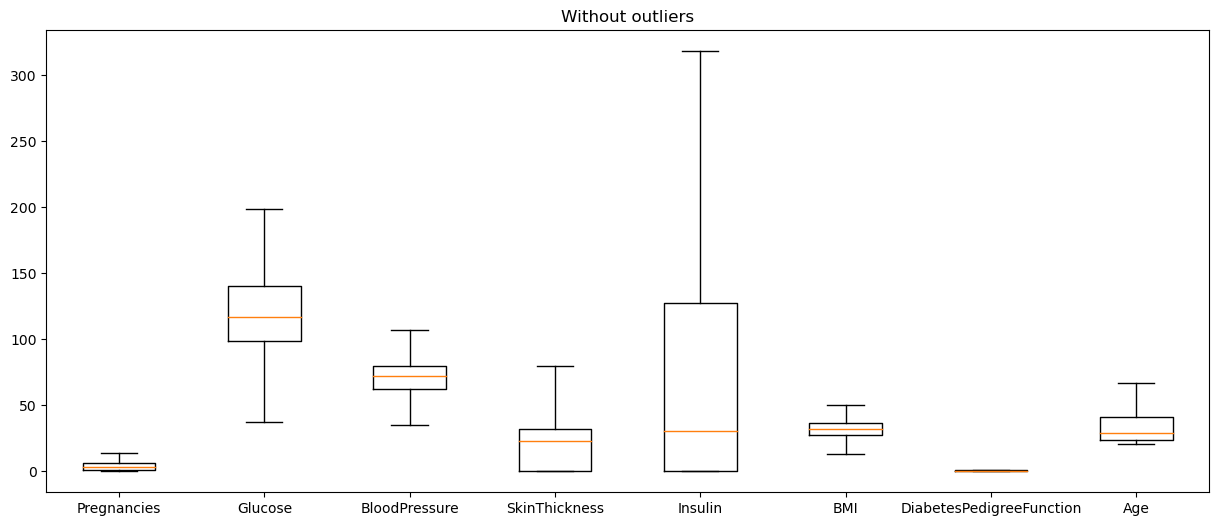

In [6]:
# Outlier'lar silindikten sonraki sütunlardaki verilerin görselleştirilmesi.

plt.figure(figsize=(15,6),dpi=100)
plt.boxplot(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']],labels=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
plt.title('Without outliers');

In [7]:
# Outcome sütununun label olarak seçilerek y ve X olarak verisetinin ayrılması.

X = df.drop('Outcome',axis=1)
y = df['Outcome']



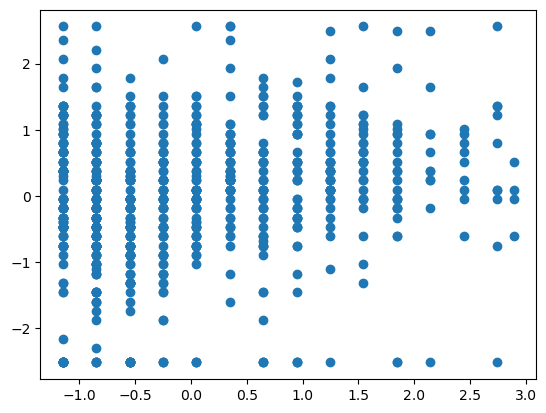

In [8]:
# Boyut azaltma

#Veriyi ayırmadan önce ölçeklendiriyoruz
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
plt.scatter(X_scaled[:, 0], X_scaled[:, 2])

In [9]:
dfTemp_X_scaled = pd.DataFrame(X_scaled, columns=['Pregnancies', 'Glucose', 'BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])

dfTemp_y = pd.DataFrame(y,columns=['Outcome'])
result = dfTemp_X_scaled.join(dfTemp_y, how='inner')



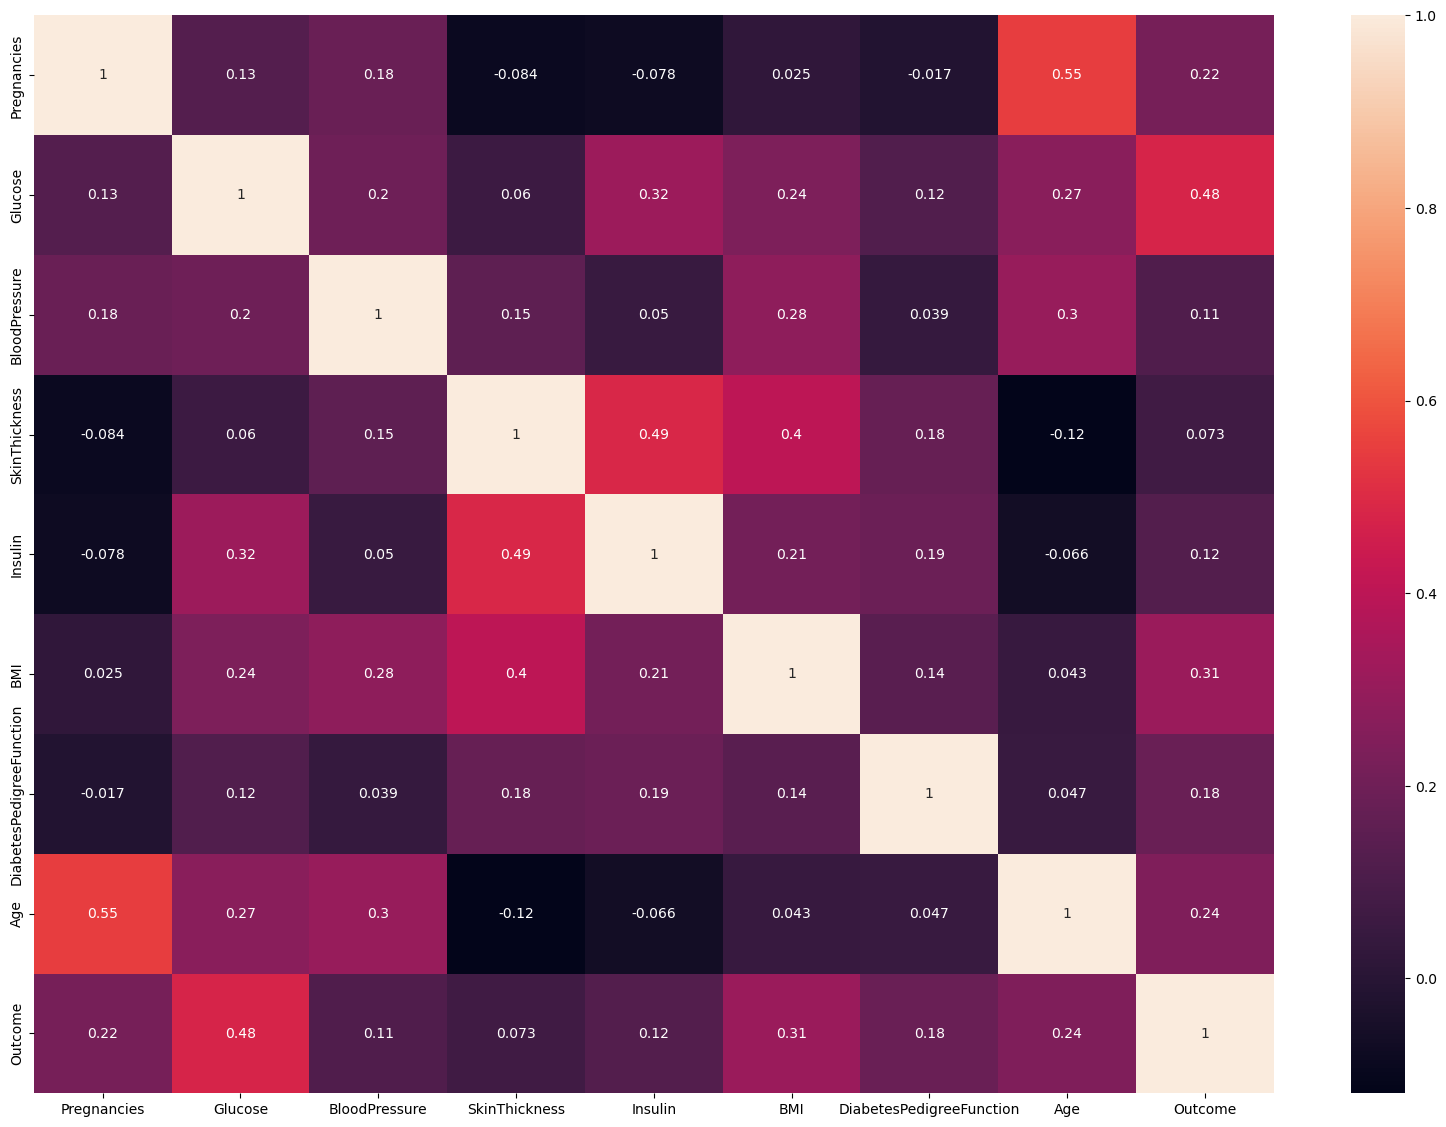

In [10]:
plt.figure(figsize = (20, 14))
sns.heatmap(result.corr(), annot = True)
plt.show()

In [11]:
data2 = result.copy()
data2['Outcome'] = y

corr = data2.corr()['Outcome'].sort_values(ascending=False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")


,Outcome
Outcome,1.000000
Glucose,0.479158
BMI,0.309739
Age,0.242702
Pregnancies,0.220392
DiabetesPedigreeFunction,0.184969
Insulin,0.124721
BloodPressure,0.113301
SkinThickness,0.073125


In [12]:
data2 = data2.drop(columns = ['Insulin', 'BloodPressure','SkinThickness'])


In [13]:
XTemp = data2.drop('Outcome',axis=1)
y = data2['Outcome']
#data2.to_excel("test.xlsx")

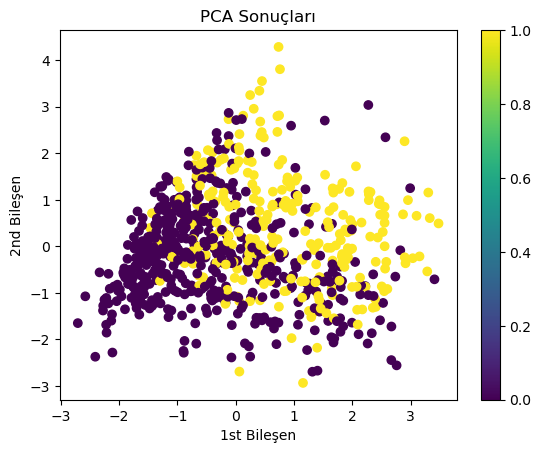

In [14]:
pca = PCA(n_components=4)

# PCA ile boyut azaltma
X_pca = pca.fit_transform(XTemp)

explained_variance_ratio = pca.explained_variance_ratio_  # Var
components = pca.components_  # özvektörler

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('1st Bileşen')
plt.ylabel('2nd Bileşen')
plt.title('PCA Sonuçları')
plt.colorbar()
plt.show()

In [15]:
# Train ve test ayrışımı.

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20,stratify=y, random_state=42)

# Machine Learning Algorithms

### Logistic Regression

In [16]:
# Logisitic Regression için model oluşturulması

log_model = LogisticRegression(class_weight='balanced')

In [17]:
# Modelin train verileri ile çalıştırılması ve tahminlerinin yapılması

log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)

In [18]:
# Hata ve başarı oranları için Confusion Matrix oluşturma

confusion_matrix(y_test,y_pred)

array([[73, 27],
       [15, 39]])

In [19]:
# Sınıflandırma sonucu değerlendirme metriklerinin rapor edilmesi

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       100
           1       0.59      0.72      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.73      0.73       154



In [20]:
model_tune_lr = LogisticRegression(random_state=42,max_iter=7000,solver='liblinear')
param_grid = [
    {
    'penalty':['l1','l2'] ,
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]
grid = GridSearchCV(model_tune_lr,param_grid=param_grid,cv=10)
grid.fit(X_train,y_train)
grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [21]:
y_proba_train_lr_pt = grid.predict_proba(X_train)
y_pred_train_lr_pt = (y_proba_train_lr_pt[:,1]>=0.37599)
print(classification_report(y_train,y_pred_train_lr_pt,zero_division=0) )

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       400
           1       0.64      0.72      0.68       214

    accuracy                           0.76       614
   macro avg       0.74      0.75      0.74       614
weighted avg       0.77      0.76      0.76       614



In [22]:
test_recall_lr = recall_score(y_train, y_pred_train_lr_pt, average='macro')
print("Test recall: ", test_recall_lr)

Test recall:  0.7510630841121495


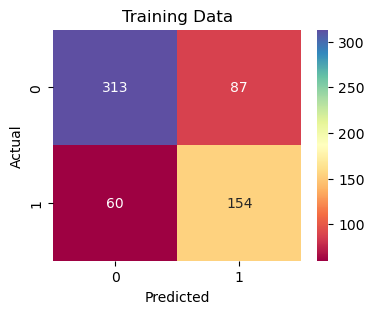

In [23]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train,y_pred_train_lr_pt),annot=True,fmt='d', cmap='Spectral')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Training Data');

### KNN

In [24]:
# KNN için model oluşturulması

math.sqrt(len(y_test))
knn = KNeighborsClassifier(n_neighbors= 11,p=2,metric='euclidean')

# Modelin train verileri ile çalıştırılması 

knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [25]:
# Tahminlerinin yapılması

y_pred =knn.predict(X_test)

In [26]:
# Sınıflandırma sonucu değerlendirme metriklerinin rapor edilmesi
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



In [27]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Example values, you can modify this
    'metric': ['euclidean', 'manhattan']  # Example values, you can modify this
}

In [28]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=10)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9]})

In [29]:
# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)
test_recall_knn = recall_score(y_test, y_pred, average='macro')
print("Test recall: ", test_recall_knn)

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 5}
Best score:  0.7459816073570572
Test accuracy:  0.7532467532467533
Test recall:  0.7362962962962962


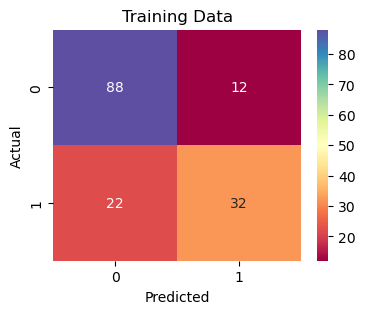

In [30]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d', cmap='Spectral')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Training Data');

## Random Forest

In [31]:
rfc= RandomForestClassifier(n_estimators=10)
rfc.fit(X_train,y_train)

y_train_pred_rf =rfc.predict(X_train)
y_train_prob_rf =rfc.predict_proba(X_train)[:,1]

print("Accuracy Score of train", accuracy_score(y_train,y_train_pred_rf))
print("AUC of the train ", roc_auc_score(y_train,y_train_prob_rf))
test_recall_rf = recall_score(y_train, y_train_pred_rf, average='macro')
print("Test recall: ", test_recall_rf)

Accuracy Score of train 0.988599348534202
AUC of the train  0.9990245327102804
Test recall:  0.984731308411215


In [32]:
print(classification_report(y_train,y_train_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       1.00      0.97      0.98       214

    accuracy                           0.99       614
   macro avg       0.99      0.98      0.99       614
weighted avg       0.99      0.99      0.99       614



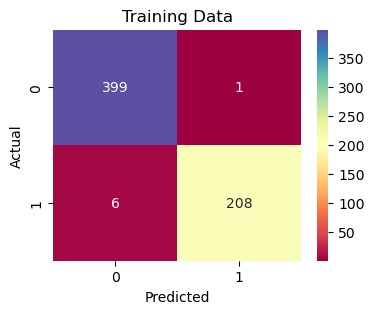

In [33]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train,y_train_pred_rf),annot=True,fmt='d', cmap='Spectral')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Training Data');